## First approach: ClearMap

As I explained last week the ClearMap implementation focuses on a series of layered image processing filtering, the key step being the difference of gaussians. I was unable to implement the backend last week, however I fixed the error and am now able to display everything.

In [6]:
%matplotlib inline
import os
import ClearMap.IO as io
import ClearMap.Settings as settings
filename = os.path.join(settings.ClearMapPath, 'data/clarity0012.tif')

In [7]:
import ClearMap.Visualization.Plot as clrplt

In [8]:
# data = io.readData(filename);
# clrplt.plotTiling(data);
#'/root/plotter.py'

#import subprocess
#with open("/root/output.png", "w+") as output:
#    subprocess.call(["python", "/root/plotter.py"], stdout=output);

In [9]:
data = io.readData(filename);
#clrplt.plotTiling(data);
#clrplt.plotTiling(data, inverse = True);

In [10]:
#Tried to hack the code by manually editing the backend plot generation to save images. Didn't work'

# from PIL import Image

# img = Image.open('/root/output.png')
# img.show() */

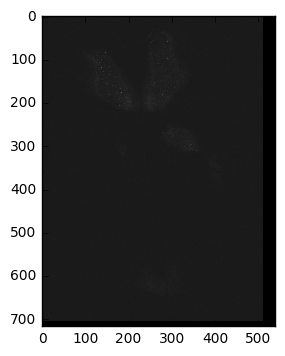

In [11]:
clrplt.plotTiling(data, inverse = False);

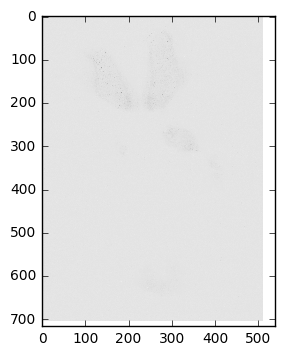

In [12]:
clrplt.plotTiling(data, inverse = True);

Image Processing Suite

Background Removal: save: None
Background Removal: size: None


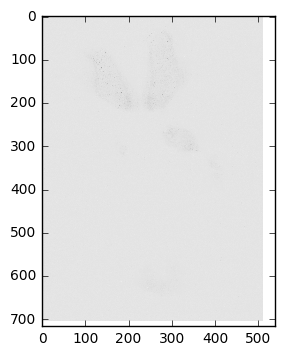

In [14]:
import ClearMap.ImageProcessing.BackgroundRemoval as bgr
dataBGR = bgr.removeBackground(data.astype('float'), verbose = True);
clrplt.plotTiling(dataBGR, inverse = True);

DoG: save  : None
DoG: sigma2: None
DoG: sigma : None
DoG: size  : None
DoG: elapsed time: 0:00:00


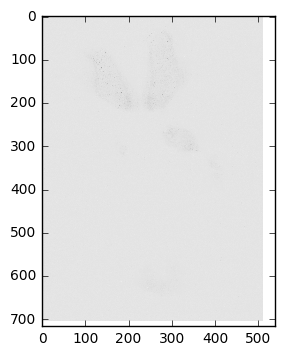

In [16]:
from ClearMap.ImageProcessing.Filter.DoGFilter import filterDoG
dataDoG = filterDoG(dataBGR, verbose = True);
clrplt.plotTiling(dataDoG, inverse = True, z = (10,16));

Extended Max: threshold: 10
Extended Max: save     : None
Extended Max: hMax     : None
Extended Max: size     : 5
Extended Max: elapsed time: 0:00:02
plotTiling: number of tiles 456 very big! Clipping at 20!


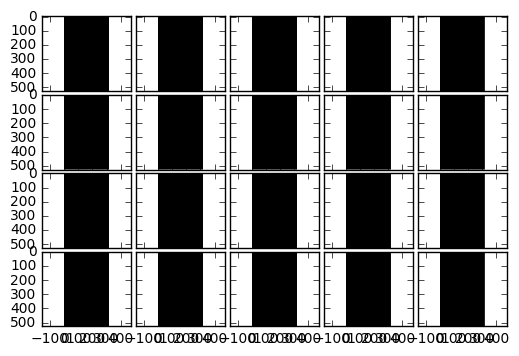

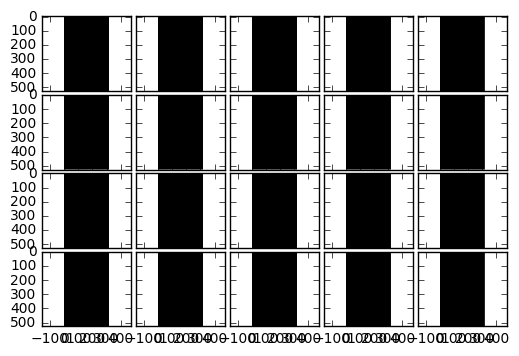

In [21]:
from ClearMap.ImageProcessing.MaximaDetection import findExtendedMaxima
dataMax = findExtendedMaxima(dataDoG, hMax = None, verbose = True, threshold = 10);
clrplt.plotOverlayLabel( dataDoG / dataDoG.max(), dataMax.astype('int'))

In [22]:
from ClearMap.ImageProcessing.MaximaDetection import findCenterOfMaxima
cells = findCenterOfMaxima(data, dataMax);
print cells.shape

(26, 3)


/usr/local/lib/python2.7/dist-packages/ClearMap-0.9.2-py2.7-linux-x86_64.egg/ClearMap/Visualization/Plot.py:221: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cimage[p[0], p[1], p[2], :] = pointColor;


plotTiling: number of tiles 456 very big! Clipping at 20!


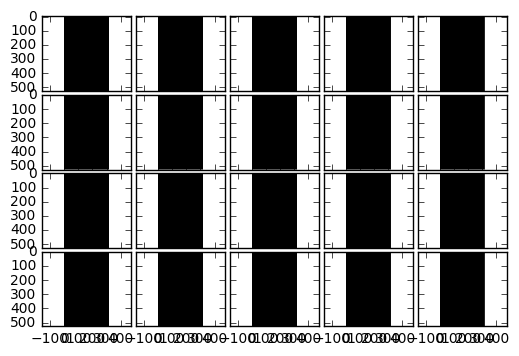

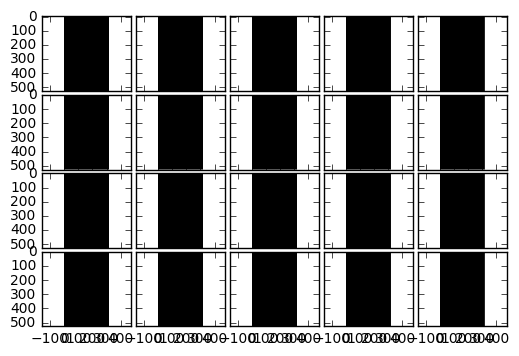

In [23]:
clrplt.plotOverlayPoints(data, cells)

Cell Shape Detection

/usr/local/lib/python2.7/dist-packages/ClearMap-0.9.2-py2.7-linux-x86_64.egg/ClearMap/Analysis/Voxelization.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vox[points[i,0], points[i,1], points[i,2]] += weights[i];


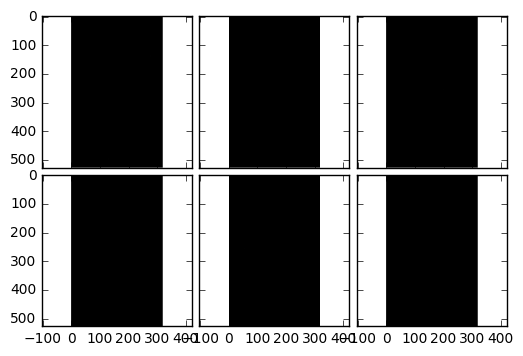

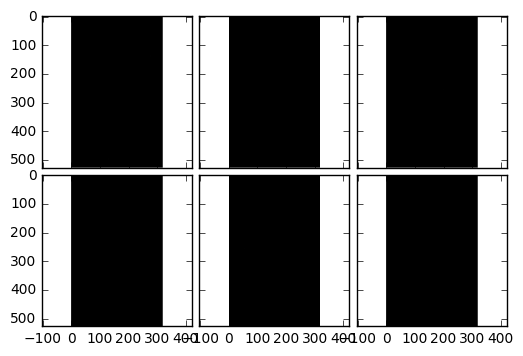

In [24]:
from ClearMap.ImageProcessing.CellSizeDetection import detectCellShape
dataShape = detectCellShape(dataDoG, cells, threshold = 15);
clrplt.plotOverlayLabel(dataDoG / dataDoG.max(), dataShape, z = (10,16))

In [25]:
from ClearMap.ImageProcessing.CellSizeDetection import findCellSize, findCellIntensity
cellSizes = findCellSize(dataShape, maxLabel = cells.shape[0]);
cellIntensities = findCellIntensity(dataBGR, dataShape, maxLabel = cells.shape[0]);

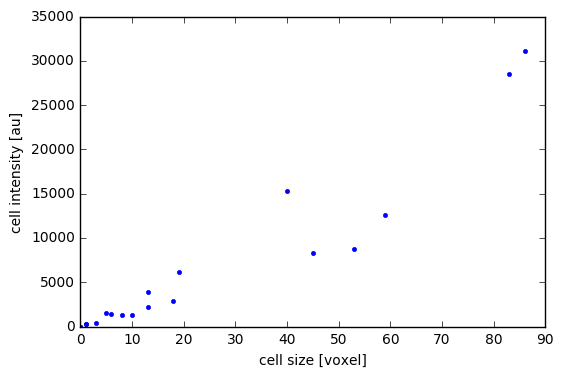

In [26]:
import matplotlib.pyplot as mpl
mpl.figure()
mpl.plot(cellSizes, cellIntensities, '.')
mpl.xlabel('cell size [voxel]')
mpl.ylabel('cell intensity [au]')

## Second approach: http://dx.doi.org/10.1371/journal.pcbi.1004970
Accurate Automatic Detection of Densely Distributed Cell Nuclei in 3D Space

Approach details:
    - Main focus area: time-lapse 3D calcium imaging data
        - "Spot" detection

Implementation
    - Blob detection
        - Background filtering
        - Gaussian blur
        - Background intensity thresholding
        - Local intensity peaks used for 3D seeded watershed
    - Blob separation
        - angle, area, curvature, and distance measurements calculated as features
        - depending on these parameters blobs are either split or joined depending on concavity
    - Second round of watershed
    - Ellipsoid fitting based off of results
    
Ideal case
![Dense](https://upload.wikimedia.org/wikipedia/commons/e/ee/Gnf-segmented-41-closeup.png)

Benefits
    - Concavity estimation algorithm is very interesting

Negatives
    - Very simple approach besides the concavity estimation
    - Don't think our images will work, algorithm requires distinct difference between background and cells

## Third Approach: Classic approach

https://www.robots.ox.ac.uk/~vgg/publications/2013/El-Labban13a/el-labban13a.pdf

Approach details:
    - Details major computer vision techniques used in the field

Implementation categories
    - Blobl detection
    - Thresholding
    - Watershed
    - Level setting
    
Level setting/Active contours
    - Good for use with low contrast boundaries - as long as it can find at least one contour, based on the pixel behavior around the contour can stretch the arc to a predicted pixel value to complete the segmentation

## Fourth Approach: Unconventional approaches
http://ir.uiowa.edu/cgi/viewcontent.cgi?article=3047&context=etd

Approach details
    - Convolutional neural networks
        - Very simple 2 layer approaches seem feasible
        - Requires training data from Ailey
    - Time series analysis based on morphological transformations over the Z axis
        - Not relevant
    - Peak tracing
        - Using peak intensity values as a center, approximate areas of cell using blurring techniques
        - Very rudimentary approach and with our data especially would most likely not work well

## Fifth Approach: Pixel training

Approach details: If you zoom into our data you will find that even the resolution 0 images are terrible in quality. 
![Example](https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/Tony/ipynb/poorExample.png?raw=true)

It is extremely unclear what is and what is not a cell. Even if we apply local histogram equalization:

In [1]:
%matplotlib inline

import math
import csv,gc
import matplotlib
import numpy as np
import cv2

#%matplotlib
BINS = 32

import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
import cv2
from PIL import Image
from numpy import *

--2017-02-13 20:00:08--  https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/Tony/ipynb/poorExample.png?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NeuroDataDesign/seelviz/raw/gh-pages/Tony/ipynb/poorExample.png [following]
--2017-02-13 20:00:08--  https://github.com/NeuroDataDesign/seelviz/raw/gh-pages/Tony/ipynb/poorExample.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NeuroDataDesign/seelviz/gh-pages/Tony/ipynb/poorExample.png [following]
--2017-02-13 20:00:08--  https://raw.githubusercontent.com/NeuroDataDesign/seelviz/gh-pages/Tony/ipynb/poorExample.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.56.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

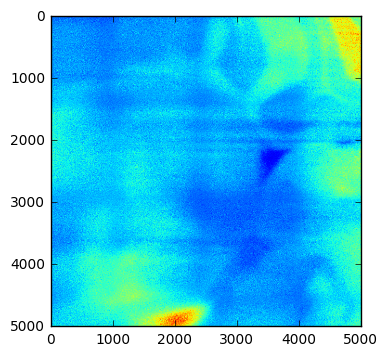

In [4]:
!wget -O poorExample.png https://github.com/NeuroDataDesign/seelviz/blob/gh-pages/Tony/ipynb/poorExample.png?raw=true
im = array(Image.open('poorExample.png'))
plt.imshow(im)

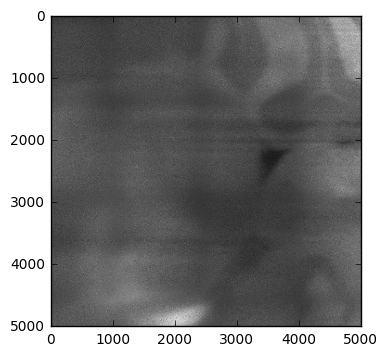

In [9]:
im = array(Image.open('poorExample.png').convert('L'))
plt.imshow(im, cmap='gray')

As you can see the heatmap shows a large intensity cloud near the 2000 mark at the x axis. The main question is how can we classify this with a set number of points?

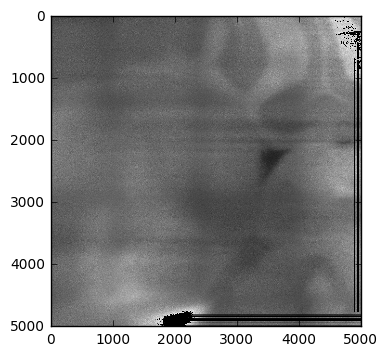

In [11]:
#Basic Thresholding

import Image
import numpy as np
import scipy.ndimage

image = np.asarray(im)
data = np.array(image)
threshold = 200
window = 10 # This is the "full" window...
new_value = 0

mask = data > threshold
mask = scipy.ndimage.uniform_filter(mask.astype(np.float), size=window)
mask = mask > 0
data[mask] = new_value

plt.imshow(np.asarray(data), cmap='gray')

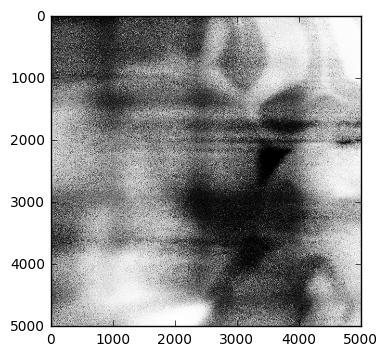

In [14]:
#Global Histogram Equalization

equ = cv2.equalizeHist(im)
plt.imshow(equ, cmap='gray')

2091649246
 


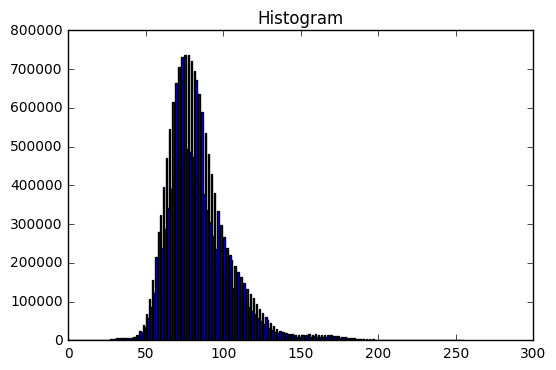

 
 
[ 41  32   9 ..., 237 131 253]
3285343843
 


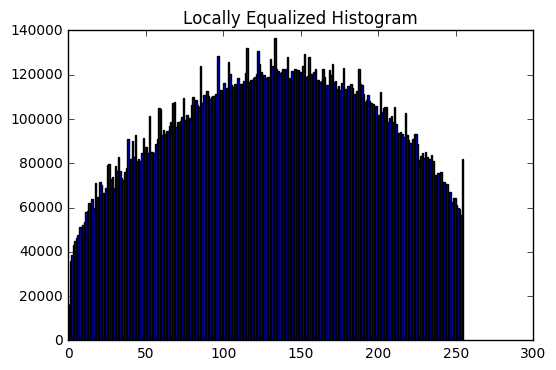

In [15]:
img = im

#Local Histogram Equalization

imgflat = img.reshape(-1)
print imgflat.sum()

print " "
fig = plt.hist(imgflat, bins=255)
plt.title('Histogram')
plt.show()

print " "

#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE()

#img_grey = np.array(img * 255, dtype = np.uint8)
#threshed = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)

cl1 = clahe.apply(img)
 
#cv2.imwrite('clahe_2.jpg',cl1)
#cv2.startWindowThread()
#cv2.namedWindow("adaptive")
#cv2.imshow("adaptive", cl1)
#cv2.imshow("adaptive", threshed)
#plt.imshow(threshed)

print " "

localimgflat = cl1.reshape(-1)
print localimgflat
print localimgflat.sum()

print " "
fig = plt.hist(localimgflat, bins=255)
plt.title('Locally Equalized Histogram')
plt.show()

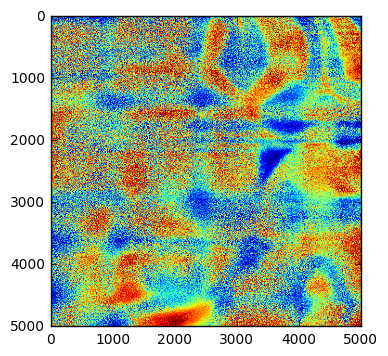

In [16]:
plt.imshow(cl1)

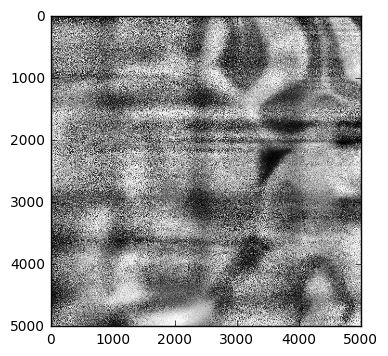

In [17]:
plt.imshow(cl1, cmap = 'gray')

If we have any training data we can use pixel classification - by having a group of pixels, say a square 3 by 3, we can classify cells

## Sixth Approach Spot/Speckle detection